# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [4]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 89.8MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [58]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.layers import SimpleRNN, LSTM, Dense
from keras.models import Sequential
from keras.losses import mean_squared_error

In [110]:
df = pd.read_csv('/content/Traffic Data.csv')

- for plotting

In [96]:
dfs=pd.read_csv('/content/Traffic Data.csv',index_col='date_time')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [91]:
df.shape

(20000, 7)

In [92]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


- time series data:

In [111]:
df['date_time'] = pd.to_datetime(df['date_time'])

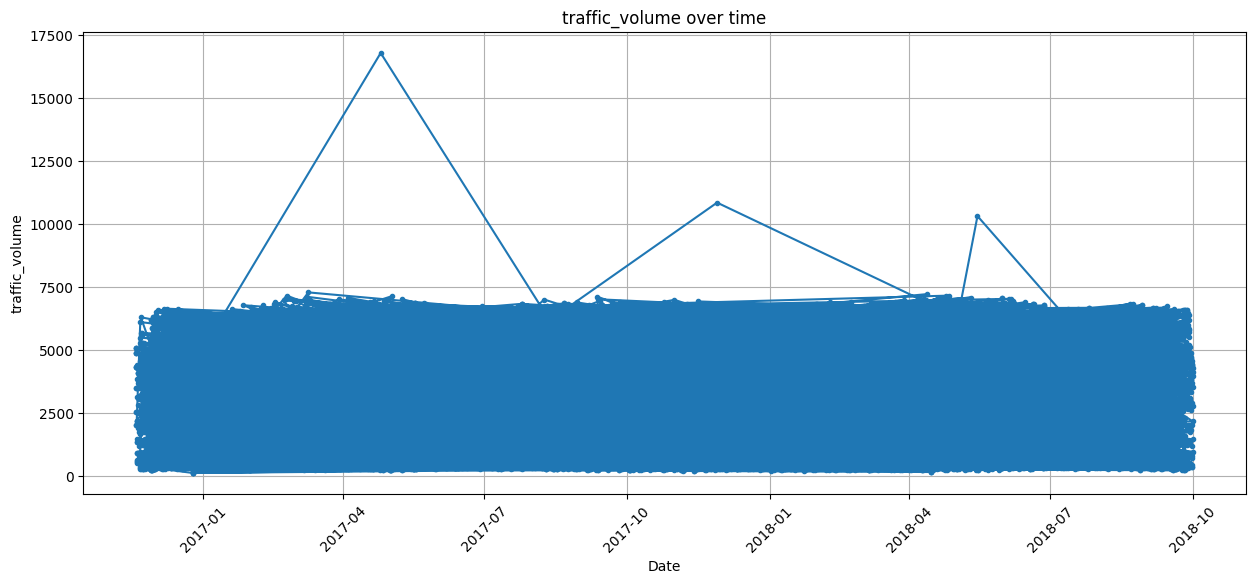

In [112]:
plt.figure(figsize=(15, 6))
plt.plot(df['date_time'], df['traffic_volume'], marker='.')
plt.title('traffic_volume over time')
plt.xlabel('Date')
plt.ylabel('traffic_volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- Seasonal Decomposition:

In [113]:
df=df.dropna()

In [114]:
results=seasonal_decompose(df['traffic_volume'], model='additive',period=7)

In [ ]:
results.plot()

it is working but taking longer time to plot so i did not run it to save time

- scatter plots:

<Axes: xlabel='traffic_volume', ylabel='temp'>

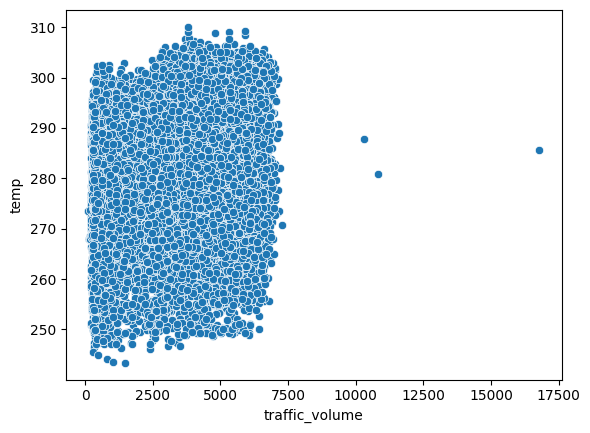

In [115]:
sns.scatterplot(data=df,x='traffic_volume', y='temp')

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [116]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [117]:
df=df.dropna()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


- Shift Method:

In [118]:
df['prev_traffic_volume'] = df['traffic_volume'].shift()

- Difference Method:

In [119]:
df['Difference between traffic_volume'] = df['traffic_volume'].diff()

- Day of the week:

In [120]:
df['Day_Week'] = df['date_time'].dt.dayofweek

- Month:

In [121]:
df['Month'] = df['date_time'].dt.month

- Day of the year

In [122]:
df['Day_Year'] = df['date_time'].dt.dayofyear

In [123]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,prev_traffic_volume,Difference between traffic_volume,Day_Week,Month,Day_Year
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,NaN,NaN,6,8,239
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,1209.0,39.0,3,9,249
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,1248.0,3354.0,4,8,237
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,4602.0,-1764.0,3,11,313
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2838.0,2956.0,3,11,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00,6601.0,-3878.0,2,6,157
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00,2723.0,3172.0,2,10,298
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00,5895.0,-4763.0,2,3,87
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00,1132.0,4393.0,0,2,43


In [124]:
df=df.dropna()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

- Note i did the scaling before splitting the data

In [125]:
scaler = MinMaxScaler()

In [126]:
features = ['temp','rain_1h','snow_1h','clouds_all','prev_traffic_volume',
            'Difference between traffic_volume','Day_Week','Month','Day_Year']

target = ['traffic_volume']

In [127]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]
scaled_train_features = scaler.fit_transform(train_df[features])
scaled_test_features = scaler.transform(test_df[features])
scaled_train_target = scaler.fit_transform(train_df[target])
scaled_test_target = scaler.transform(test_df[target])
timesteps = 20

In [128]:
def create_sequences(features, target, timesteps):
  X, y = [], []
  for i in range(len(features) - timesteps):
    X.append(features[i:i+timesteps])
    y.append(target[i+timesteps])
  return np.array(X),np.array(y)

In [129]:
X_train, y_train = create_sequences(scaled_train_features, scaled_train_target, timesteps)
X_test, y_test = create_sequences(scaled_test_features, scaled_test_target, timesteps)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

- i selected RNN and LSTM since they are diffrent to each other where one handels vanishing and exploring gradintes and the other not also i want to see other diff

In [130]:
X_train.shape

(15963, 20, 9)

In [131]:
model = Sequential([
    SimpleRNN(32,return_sequences=True ,input_shape=(20,9,)),
    SimpleRNN(32,return_sequences=False),
    Dense(1)

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [132]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 20, 32)              │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [138]:
model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lo

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [139]:
y_pred1= model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [140]:
l1=mean_squared_error(y_test,y_pred1)

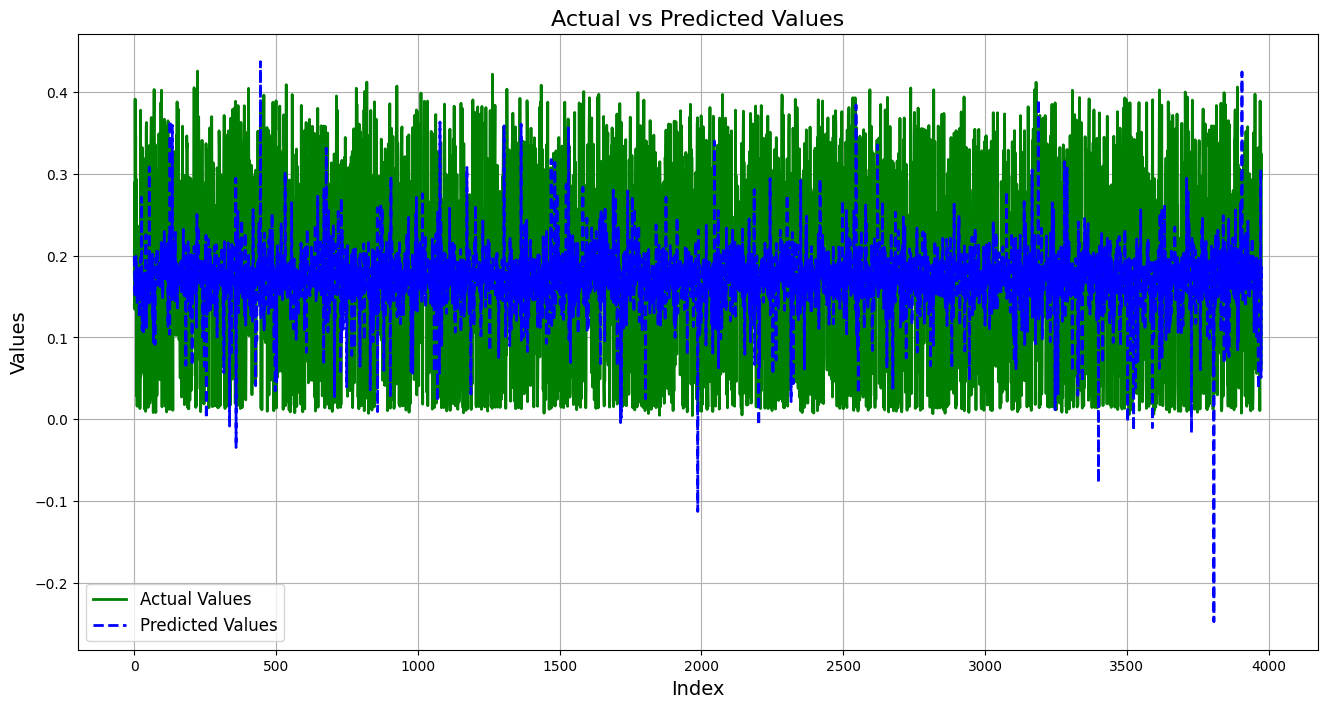

In [141]:
index = np.arange(len(y_test))
plt.figure(figsize=(16, 8))
plt.plot(index, y_test, label='Actual Values', color='green', linewidth=2)
plt.plot(index, y_pred1, label='Predicted Values', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Actual vs Predicted Values', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [142]:
model2 = Sequential([
    LSTM(32,return_sequences=True ,input_shape=(20,9,)),
    LSTM(32,return_sequences=False),
    Dense(1)

])

In [143]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 20, 32)              │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,729 (53.63 KB)

 Trainable params: 13,729 (53.63 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
model2.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [145]:
model2.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - lo

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [146]:
y_pred2 = model2.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [147]:
l2=mean_squared_error(y_test,y_pred2)

In [148]:
eval2=model2.evaluate(X_test,y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mse: 0.0138


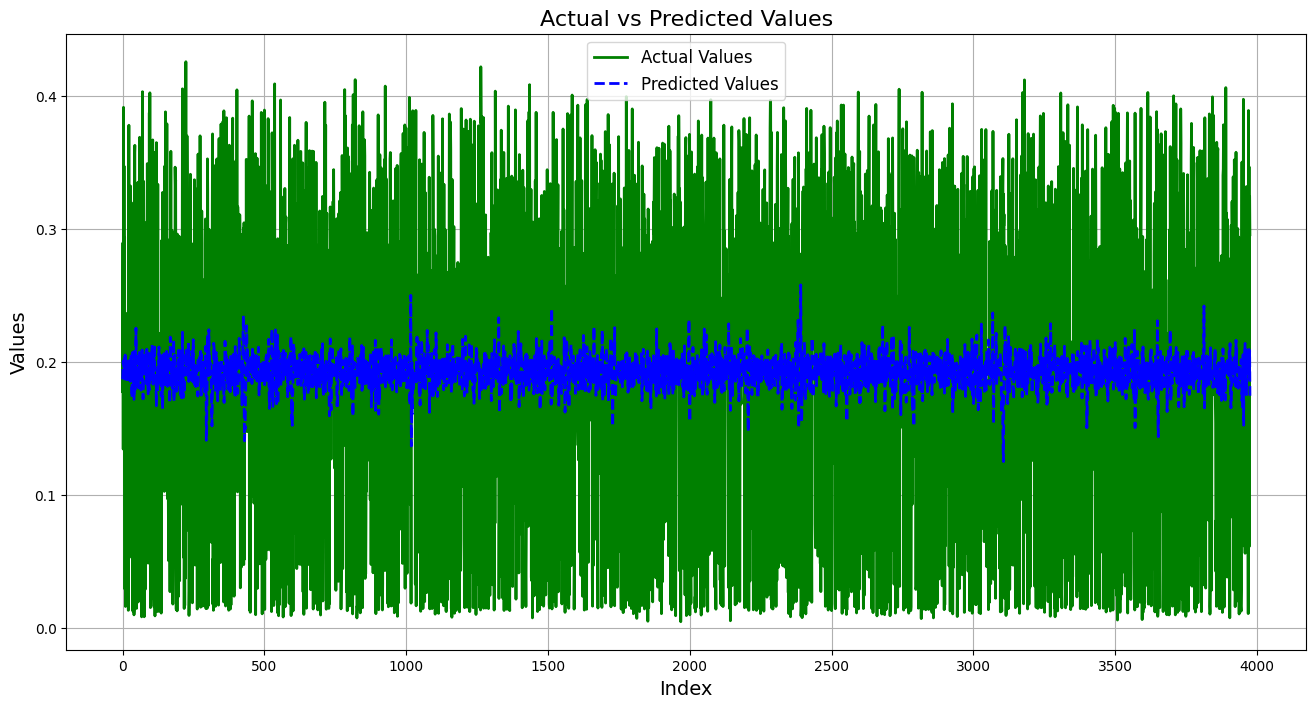

In [149]:
index = np.arange(len(y_test))
plt.figure(figsize=(16, 8))
plt.plot(index, y_test, label='Actual Values', color='green', linewidth=2)
plt.plot(index, y_pred2, label='Predicted Values', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Actual vs Predicted Values', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1) i used dropnull since after each converting i get Nan value so droping it will be the best choice also i used min max scaling for the data before spliting

2) i add new columns as i soppost to do where i finde month day year also the diff and shift as new columns so now the model can understand more date info and capture more historical patterns for forcating

3) i selected RNN and LSTM since they are diffrent to each other where one handels vanishing and exploring gradintes and the other not also i want to see other diff both of them are 2 layers

4) accutly for there was no time to try other paramters but i think these numbers may be sutable by training and observation

5) since we are working with seq data and forcasting the regresion methods will be more sutable to eval the model i used mse as metres and adam as optimizer

6) nothing

7) will there are nether overfitting or underfitting but if you consest i will say we may be on underfitting since i think the model need totrain for more epoches but the test time is not enogh to me sorry and ty for tour understanding.

8) i think by training more and understand the most important features that will help us on the forcasting task will make the model prediction more accurated and improved.